# Данные для обучения и оценки модели

* Данные разбиваем по исследованиям
* Используем набор снимков, ограниченный по z-коорединате, чтобы уменьшить время на обучение
* Обучаем и тестируем только на снимках с узлами
* Делаем выборки представительными по кол-ву узлов
* Близкие узлы в разных плоскостях считаем разными, тоже самое для пересекающихся в одной плоскости

In [26]:
import numpy as np
import pandas as pd 

import dill
import joblib

from sklearn.model_selection import train_test_split

In [27]:
plans = pd.read_csv('data/plans')
nodules = pd.read_csv('data/nodules')

In [28]:
nodules.head(2)

,study_id,nodule_id,diameter,x,y,z,comment,decision,id,ml,type,instance_uid,location,dcm_path,IsLung,IsBody,z_level
0,RLS5A09001KDC6-K00008714,002,6.0,400.0,281.0,1698.3,неверный размер,confirmed_partially,СВЕ,False,м,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,115.2,E:\data\For_Publication_v3\Dicom\RLAD31D006-11...,False,True,0.684384
1,RLS5A09001KDC6-K00008714,002,6.0,400.0,281.0,1698.3,неверный размер,confirmed_partially,СВЕ,False,м,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,115.2,E:\data\For_Publication_v3\Dicom\RLAD31D006-11...,True,False,0.684384


In [29]:
plans.head(2)

,study_id,instance_uid,z_mm,location,dcm_path,IsLung,IsBody,HasNodules,z_level
0,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,300.0,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,False,True,False,0.0
1,RLS5A09001KDC6-K00004273,1.2.276.0.7230010.3.1.3.1417964692.10880.15687...,1660.5,300.0,E:\data\For_Publication_v3\Dicom\RLAD31D006-12...,True,False,False,0.0


### Ограничим выборку

Выберем снимки из диапазона по z, в котором найдено большое кол-во узлов

In [30]:
Z_LEVEL_MIN = 0.60
Z_LEVEL_MAX = 0.80

In [31]:
restricted_plans = plans[plans['IsLung'] & (plans['z_level'] >= Z_LEVEL_MIN) & (plans['z_level'] <= Z_LEVEL_MAX) & plans['HasNodules']]
len(restricted_plans)

370

105


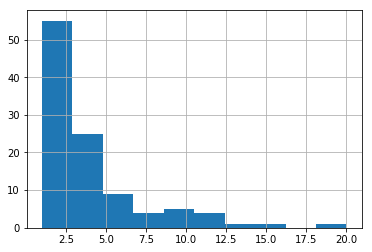

In [32]:
restricted_studies = restricted_plans['study_id'].value_counts()
print(len(restricted_studies))
restricted_studies.hist()

In [33]:
target_studies = restricted_studies.index

In [34]:
restricted_nodules = nodules[nodules['IsLung'] & nodules['study_id'].isin(target_studies)]
len(restricted_nodules)

1363

### Данные для итоговой оценки

В приложениях будем искать патологии с помощью моделей, обученных на снимках из предыдущих исследований. Т.к. данных о времени исследования нет, упорядочим по id.

Вероятно, распределения исследований меняются со временем, поэтому для финальной валидации используем отложенную выборку - не представительную и без shuffle (если бы были доступны timestamp'ы, отсортировал бы по ним)

In [35]:
studies_model, studies_test, _, _ = train_test_split(target_studies.sort_values(), np.zeros(len(target_studies)), test_size=0.1, shuffle=True, random_state=5)

In [36]:
len(studies_test), len(restricted_plans[restricted_plans['study_id'].isin(studies_test)])

(11, 47)

In [37]:
len(studies_model), len(restricted_plans[restricted_plans['study_id'].isin(studies_model)])

(94, 323)

### Данные для обучения модели

Сохраним в выборках распределение по кол-ву снимков 

In [38]:
plans_dist = pd.Series(data=np.zeros(len(studies_model), dtype=np.int8), index=studies_model)

In [39]:
plans_by_study = restricted_plans[restricted_plans['study_id'].isin(studies_model)]['study_id'].value_counts()
plans_dist = plans_by_study.astype('int')

In [40]:
plans_dist[plans_dist >= 10] = 10
plans_dist[(plans_dist >= 6) & (plans_dist < 10) ] = 6

In [41]:
plans_dist.value_counts()

1     34
3     18
2     16
10     8
5      7
4      6
6      5
Name: study_id, dtype: int64

In [42]:
studies_model_train, studies_model_valid, _, _ = train_test_split(studies_model, np.zeros(len(studies_model)), test_size=0.2, stratify=plans_dist, shuffle=True,  random_state=5)

In [43]:
len(studies_model_valid), len(restricted_plans[restricted_plans['study_id'].isin(studies_model_valid)])

(19, 79)

In [44]:
len(studies_model_train), len(restricted_plans[restricted_plans['study_id'].isin(studies_model_train)])

(75, 244)

### Сохраним выборки исследовании

In [45]:
restricted_nodules.to_csv("data/restricted_nodules")
restricted_plans.to_csv("data/restricted_plans")

In [46]:
joblib.dump(studies_model_train, "data/train")
joblib.dump(studies_model_valid, "data/valid")
joblib.dump(studies_test, "data/test")

['data/test']